# 단어 Level로 번역기 업그레이드

### Step 1. 데이터 전처리

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [2]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 178009


,eng,fra,cc
84949,I was glad to hear the news.,J'étais contente d'entendre la nouvelle.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
45494,We're getting married.,Nous nous marions.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
139894,It looks like l've come at a bad time.,On dirait que je tombe mal.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
71033,I've learned so much here.,J'ai tant appris ici.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
32420,Tom lives in a cave.,Tom vit dans une grotte.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


In [3]:
lines = lines[['eng', 'fra']][:33000] # 33,000개 샘플 사용
lines.sample(5)

,eng,fra
4583,Wait a while.,Attends un moment !
24579,I never got caught.,Je ne m'y suis jamais fait prendre.
4859,You're stuck.,Vous êtes plantés.
19977,I'm feeling great.,Je me sens bien !
8826,Leave me alone!,Fiche-moi la paix !


In [4]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = sentence.strip()
    sentence = sentence.split(" ")
    return sentence

In [5]:
def preprocess_sentence_decoder(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>'
    sentence = sentence.split(" ")
    return sentence

In [6]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_decoder(x))

In [7]:
lines.eng.sample(5)

18049      [are, you, guys, free, ?]
7516          [don, t, fall, off, !]
26091    [take, a, sip, of, this, .]
14848       [i, have, a, problem, .]
24036     [i, brought, you, this, .]
Name: eng, dtype: object

In [8]:
lines.fra.sample(5)

27958                [<start>, vous, tes, idiot, ., <end>]
14275               [<start>, c, est, mon, prof, ., <end>]
28152              [<start>, on, t, a, pr, venu, ., <end>]
4546          [<start>, tom, tait, en, s, curit, ., <end>]
17170    [<start>, nous, sommes, un, tantinet, en, reta...
Name: fra, dtype: object

### Step 2. 텍스트를 숫자로 변환

In [9]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines.eng)
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
input_text[:3]

[[30, 1], [1132, 1], [1132, 1]]

In [10]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines.fra)
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
target_text[:3]

[[1, 91, 12, 2], [1, 1068, 12, 2], [1, 1068, 3, 2]]

In [11]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4662
프랑스어 단어장의 크기 : 7326


In [12]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [13]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4662
프랑스어 단어장의 크기 : 7326
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [14]:
sos_token = '<start>'
eos_token = '<end>'

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [15]:
print(decoder_input[:5])
print(decoder_target[:5])

[[1, 91, 12], [1, 1068, 12], [1, 1068, 3], [1, 928, 12], [1, 2190, 12]]
[[91, 12, 2], [1068, 12, 2], [1068, 3, 2], [928, 12, 2], [2190, 12, 2]]


In [16]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [17]:
print(encoder_input[0])

[30  1  0  0  0  0  0  0]


In [18]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 3054 30692 28036 ... 29359  3655 12438]


In [19]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [20]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [21]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)

print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 17)
(30000, 17)
(3000, 8)
(3000, 17)
(3000, 17)


### Step 4. Embedding layer

In [22]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [23]:
# encoder embedding
encoder_inputs = Input(shape=(None,))

enc_emb = Embedding(eng_vocab_size, 256, input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(units = 256, return_state = True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [24]:
# decoder embedding
decoder_inputs = Input(shape=(None,))

dec_emb = Embedding(fra_vocab_size, 256)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = 256, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [25]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    1193472     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    1875456     input_2[0][0]                    
_______________________________________________________________________________________

In [26]:
history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 40)

Epoch 1/40
235/235 [==============================] - 12s 51ms/step - loss: 1.9142 - acc: 0.7054 - val_loss: 1.5291 - val_acc: 0.7526
Epoch 2/40
235/235 [==============================] - 11s 46ms/step - loss: 1.3899 - acc: 0.7710 - val_loss: 1.2855 - val_acc: 0.7916
Epoch 3/40
235/235 [==============================] - 11s 46ms/step - loss: 1.1790 - acc: 0.8036 - val_loss: 1.1515 - val_acc: 0.8098
Epoch 4/40
235/235 [==============================] - 11s 46ms/step - loss: 1.0522 - acc: 0.8202 - val_loss: 1.0656 - val_acc: 0.8224
Epoch 5/40
235/235 [==============================] - 11s 46ms/step - loss: 0.9572 - acc: 0.8328 - val_loss: 0.9908 - val_acc: 0.8329
Epoch 6/40
235/235 [==============================] - 11s 47ms/step - loss: 0.8805 - acc: 0.8427 - val_loss: 0.9372 - val_acc: 0.8406
Epoch 7/40
235/235 [==============================] - 11s 47ms/step - loss: 0.8176 - acc: 0.8511 - val_loss: 0.8953 - val_acc: 0.8452
Epoch 8/40
235/235 [==============================] - 11s 47ms

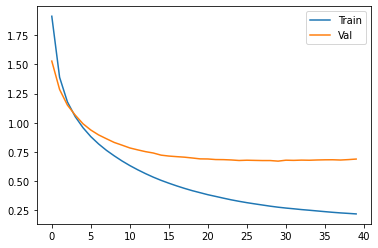

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label = 'Val')
plt.legend(['Train', 'Val'])
plt.show()

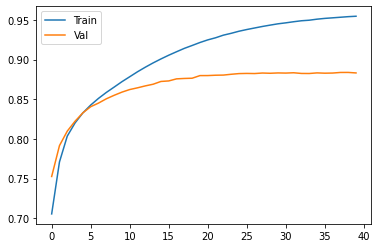

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'])
plt.show()

### Step 5. 모델 구현

In [34]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         1193472   
_________________________________________________________________
masking (Masking)            (None, None, 256)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 525312    
Total params: 1,718,784
Trainable params: 1,718,784
Non-trainable params: 0
_________________________________________________________________


In [35]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, 256)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [36]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    1875456     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
_______________________________________________________________________________________

In [37]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [38]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [39]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [40]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

### Step 6. 모델 평가

In [42]:
for seq_index in [22,330,540,770,980]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: i like that idea . 
정답 문장: j aime cette id e . 
번역기가 번역한 문장:  j j de de . . . 
-----------------------------------
입력 문장: tom has frostbite . 
정답 문장: tom a des engelures . 
번역기가 번역한 문장:  tom de de de de d
-----------------------------------
입력 문장: his play was a hit . 
정답 문장: sa pi ce de th tre a t un succ s . 
번역기가 번역한 문장:  sa sa une une un
-----------------------------------
입력 문장: you re stuck . 
정답 문장: vous tes plant . 
번역기가 번역한 문장:  t es t . . . . . 
-----------------------------------
입력 문장: shut the door . 
정답 문장: fermez la porte . 
번역기가 번역한 문장:  ferme la la la l
